<a href="https://colab.research.google.com/github/bodadaniel/Sentiment-analysis/blob/main/NLP_data_lstm_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Amazon 2018 automotive
import pandas as pd
import gzip
import json

from google.colab import drive 
drive.mount('/content/gdrive')

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df_train = getDF('/content/gdrive/MyDrive/Colab Notebooks/NLP/Automotive_5.json.gz')
df_train = df_train[['reviewerName', 'reviewText', 'overall', 'summary', 'reviewTime']]
df_train['sample_type'] = "automotive"
df_train = df_train.sample(n=int(1e6), random_state=1, ignore_index = True)
#df_train

Mounted at /content/gdrive


In [ ]:
#Amazon 2018 Video Games
df_test = getDF('/content/gdrive/MyDrive/Colab Notebooks/NLP/Video_Games_5.json.gz')
df_test = df_test[['reviewerName', 'reviewText', 'overall', 'summary', 'reviewTime']]
df_test['sample_type'] = "video_games"
df_test = df_test.sample(n=int(1e5), random_state=1, ignore_index = True)
#df_test

In [ ]:
df = pd.concat((df_train, df_test), axis = 0)
df.reset_index(inplace = True, drop= True )
df

In [ ]:
df['reviewTextLength'] = df.reviewText.str.len()
print('automotive')
print(pd.DataFrame(df[df.sample_type == 'automotive'].reviewTextLength.describe()).apply(lambda x: '%.5f' % x, axis=1))
print('')
print('video_games')
print(pd.DataFrame(df[df.sample_type == 'video_games'].reviewTextLength.describe()).apply(lambda x: '%.5f' % x, axis=1))

automotive
count    999509.00000
mean        183.79732
std         306.53312
min           1.00000
25%          32.00000
50%          90.00000
75%         211.00000
max       14323.00000
dtype: object

video_games
count    99971.00000
mean       675.65296
std       1271.15982
min          1.00000
25%         59.00000
50%        212.00000
75%        717.00000
max      32627.00000
dtype: object


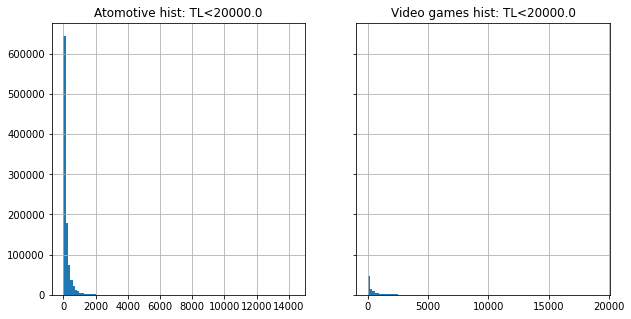

In [ ]:
import matplotlib.pyplot as plt

def plot_tl_hist(upper_bound):
  fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(10, 5))
  df[(df.sample_type == 'automotive') & (df.reviewTextLength < upper_bound)].reviewTextLength.hist(bins = 100, ax=ax[0])
  ax[0].set_title(f'Atomotive hist: TL<{upper_bound}')
  df[(df.sample_type == 'video_games') & (df.reviewTextLength < upper_bound)].reviewTextLength.hist(bins = 100, ax=ax[1])
  ax[1].set_title(f'Video games hist: TL<{upper_bound}')

plot_tl_hist(2e4)

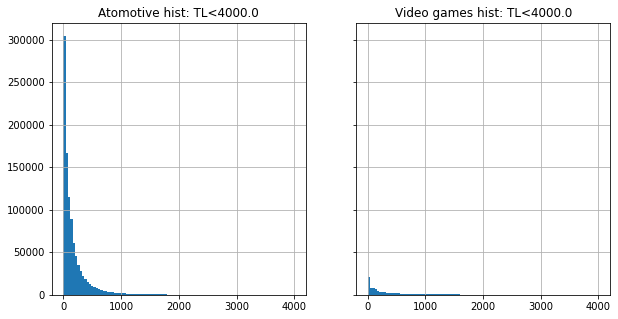

In [ ]:
plot_tl_hist(4e3)

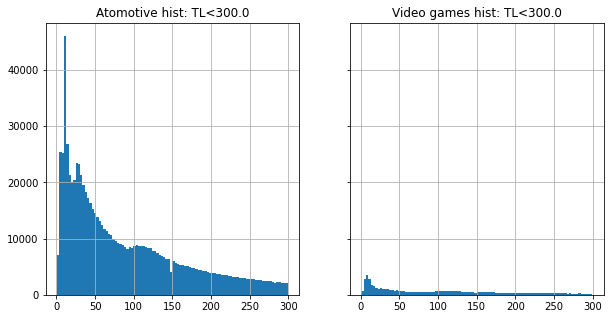

In [ ]:
plot_tl_hist(3e2)

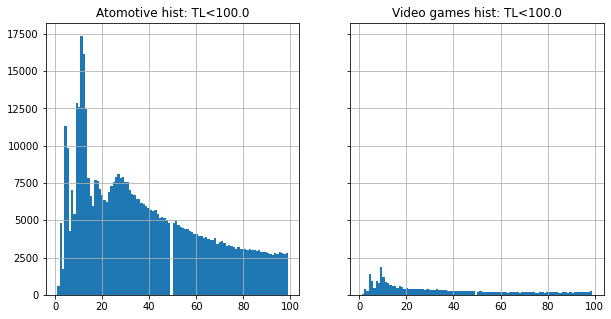

In [ ]:
plot_tl_hist(1e2)

In [ ]:
df[df.reviewTextLength < 5]

,reviewerName,reviewText,overall,summary,reviewTime,sample_type,reviewTextLength
73,JOSUE VELEZ,OK,3.0,Three Stars,"04 30, 2016",automotive,2
97,Justin G.,Good,5.0,Five Stars,"01 16, 2015",automotive,4
112,TERRY,Nice,5.0,Five Stars,"03 16, 2018",automotive,4
247,eduardo,good,4.0,Four Stars,"12 16, 2015",automotive,4
299,Mark Steppan,nice,5.0,Five Stars,"07 27, 2015",automotive,4
...,...,...,...,...,...,...,...
1099756,Norverth Jose Marquez Hernandez,cool,5.0,Five Stars,"10 5, 2015",video_games,4
1099803,Jose P,Good,3.0,"Needs more diferents things to do,is always th...","12 5, 2016",video_games,4
1099860,flavio,ok,5.0,Five Stars,"11 23, 2014",video_games,2
1099870,Jhonny B.,nice,5.0,Five Stars,"09 29, 2014",video_games,4


In [ ]:
#check max len
import pprint as pp
pp.pprint(list(df[(df.reviewTextLength == 14323) & (df.sample_type == 'automotive')].reviewText))

In [ ]:
pp.pprint(list(df[(df.reviewTextLength == 32627) & (df.sample_type == 'video_games')].reviewText))

In [ ]:
#Modify data 
df = df[(df.reviewTextLength > 1e1) & (df.reviewTextLength < 4e3)]
df['reviewText'] = df['reviewText'].str.slice(0,1000)
df['reviewTextLength'] = df.reviewText.str.len()
df.reset_index(drop = True, inplace = True)

In [ ]:
df.reviewTextLength.max()

1000

In [ ]:
! python -m spacy download en_core_web_md

import en_core_web_md
nlp = en_core_web_md.load()
from tqdm.auto import tqdm,trange

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from matplotlib import pyplot


In [ ]:
review_words=[]

for text in tqdm(df['reviewText']):
    with nlp.disable_pipes("tagger","parser","ner"):
        doc = nlp(text)
        review_words.append([token.text.lower() for token in doc])

  0%|          | 0/1018167 [00:00<?, ?it/s]

In [ ]:
print(nlp.pipe_names)

In [ ]:
df['reviewTextWords'] = review_words
df['reviewTextWordsLength'] = df.reviewTextWords.str.len()
#df

In [ ]:
class WordTokenizer():
    def __init__(self, tok_seqs, threshold=50):
        tok_counts={}
        
        for tok_seq in tqdm(tok_seqs):
            for tok in tok_seq:
                if not tok in tok_counts.keys():
                    tok_counts[tok]=1
                else:
                    tok_counts[tok]+=1

        #print(tok_counts) 
        
        self.vocab={'[PAD]':0,'[UNK]':1}
        for tok, val in tok_counts.items():
            if val>=threshold:
                self.vocab[tok]=len(self.vocab)
                
        #print("The size of the dictionary:",len(self.vocab))
        print("The size of the dictionary:",len(self.vocab), self.vocab)
    def encode(self,seq):
        encoded=[]
        for tok in seq:
            if tok in self.vocab.keys():
                encoded.append(self.vocab[tok])
            else:
                encoded.append(1)
        return encoded

WordTokenizer(df.reviewTextWords, 10)

In [ ]:
df.overall.value_counts()

5.0    717802
4.0    148523
3.0     65839
1.0     51770
2.0     34233
Name: overall, dtype: int64

In [ ]:
df = df[df.overall != 3]
df.overall = df.overall.map({1:0, 2:0, 4:1, 5:1})
df

In [ ]:
word_tokenizer = WordTokenizer(df.reviewTextWords, 10)
df['reviewTextWordsEncoded'] = df.reviewTextWords.apply(word_tokenizer.encode)
df

In [ ]:
train_df, val_df, test_df = np.split(df.sample(frac=1, random_state=1), [int(.6*len(df)), int(.8*len(df))])

train_df = train_df.sample(n=int(2e5), random_state=1, ignore_index = True)
val_df = val_df.sample(n=int(2e4), random_state=1, ignore_index = True)
test_df = test_df.sample(n=int(1e4), random_state=1, ignore_index = True)

print(train_df.shape, val_df.shape, test_df.shape)

(200000, 10) (20000, 10) (10000, 10)


In [ ]:
print('orig')
print(df.overall.value_counts())
print('train')
print(train_df.overall.value_counts())
print('valid')
print(val_df.overall.value_counts())
print('test')
test_df.overall.value_counts()

orig
1    866325
0     86003
Name: overall, dtype: int64
train
1    181942
0     18058
Name: overall, dtype: int64
valid
1    18243
0     1757
Name: overall, dtype: int64
test


1    9109
0     891
Name: overall, dtype: int64

In [ ]:

import os 
import numpy as np

embeddings_index = {}
filename = '/content/gdrive/MyDrive/Colab Notebooks/NLP/glove.6B.100d.txt'

f = open(os.path.join(filename), encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()


In [ ]:
#len(embeddings_index['growing'])
len(embeddings_index)

400000

In [ ]:
len(word_tokenizer.vocab)

28816

In [ ]:
def word_vectors(n, k, vocab, emb):
  weights_matrix = np.zeros((n, k))
  words_found = 0

  for i, word in enumerate(vocab):
      try: 
          weights_matrix[i] = emb[word]
          words_found += 1
      except KeyError:
          weights_matrix[i] = np.random.normal(scale=0.6, size=(k, ))

  weights_matrix = torch.from_numpy(weights_matrix)
  print('words_found:', words_found)
  return weights_matrix

weights_matrix_glove = word_vectors(len(word_tokenizer.vocab), 100, word_tokenizer.vocab, embeddings_index)


words_found: 24958


In [ ]:
del embeddings_index

In [ ]:
#Google
!unzip -q "/content/gdrive/MyDrive/Colab Notebooks/NLP/GoogleNews-vectors-negative300.bin.zip"

In [ ]:
import gensim
from gensim import models
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
word2vec_path = 'GoogleNews-vectors-negative300.bin'
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [ ]:
len(word2vec['apple'])

300

In [ ]:
weights_matrix_google = word_vectors(len(word_tokenizer.vocab), 300, word_tokenizer.vocab, word2vec)

words_found: 23148


In [ ]:
del word2vec

In [ ]:
def create_emb_layer(weights_matrix, non_trainable=False, padding_idx = None):
    num_embeddings, embedding_dim = weights_matrix.size()
    emb_layer = nn.Embedding(num_embeddings, embedding_dim, padding_idx)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

#create_emb_layer(weights_matrix_glove, non_trainable=False)

In [ ]:
#to use
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

def batch_iterator(df, batch_size, shuffle=True):
    if batch_size==0:
        starts=[0]
        batch_size=len(df)
    else:
        starts=np.arange(0, len(df), batch_size)
        if shuffle:
            np.random.shuffle(starts)

    for start in starts:
        batch = df[start:start+batch_size]
        bs = min(batch_size,len(df)-start)
        
        batch_len = batch["reviewTextWordsLength"] #sequence length
            
        input_tensor = torch.zeros((bs, batch["reviewTextWordsLength"].max() )).long()
        
        for idx, (seq, seq_len) in enumerate(zip(list(batch["reviewTextWordsEncoded"]),list(batch["reviewTextWordsLength"]))):
            input_tensor[idx, :seq_len] = torch.LongTensor(seq)
            

        sentiment_tensor = torch.LongTensor(list(batch["overall"]))

        yield input_tensor.to(device), sentiment_tensor.to(device), torch.tensor(batch_len.values)

cuda:0


In [ ]:
#plot
import matplotlib.pyplot as plt

def plot_loss(train_losses, valid_losses):
  fig = plt.figure(figsize=(10,6))
  ax = fig.add_subplot(1,1,1)
  ax.plot(train_losses, label='Train loss', color = 'blue')
  ax.plot(valid_losses, label='Valid loss', color = 'green')
  plt.legend()
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Loss')
  ax.set_title(f'Loss function (epoch)')

plot_loss(train_losses = [0.7, 0.8, 0.9], valid_losses = [0.4, 0.5, 0.6])

def plot_accuracy(train_accuracy, valid_accuracy):
  fig = plt.figure(figsize=(10,6))
  ax = fig.add_subplot(1,1,1)
  ax.plot(train_accuracy, label='Train accuracy', color = 'blue')
  ax.plot(valid_accuracy, label='Valid accuracy', color = 'green')
  plt.legend()
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Accuracy')
  ax.set_title(f'Accuracy (epoch)')

plot_accuracy(train_accuracy = [0.7, 0.8, 0.9], valid_accuracy = [0.4, 0.5, 0.6])

In [ ]:
#to use v3
from datetime import datetime

def train_func(model, train_df, optimizer, batch_size, GPU=False, include_length = False):
  
  model.train()

  running_loss = [] #0
  running_acc = [] #0

  for i, batch in enumerate(batch_iterator(train_df, batch_size, shuffle = True)):
    input, target, text_length = batch
    if GPU:
      input, target = input.to(device), target.to(device)      

    optimizer.zero_grad() 

    if include_length == True:
      pred = model(input, text_length)
    else:
      pred = model(input)

    loss = loss_fn(pred, target)

    #running_loss += loss.item()
    running_loss.append(loss.item())

    acc = torch.sum(pred.argmax(axis = 1) == target) / len(target) #64
    acc = acc.cpu()
    #running_acc += acc.item()
    running_acc.append(acc.item())

    loss.backward()
    optimizer.step()

  #print(running_loss / (i+1), running_acc / (i+1))

  #return running_loss / (i+1), running_acc / (i+1)
  return np.mean(running_loss), np.mean(running_acc)

def test_func(model, val_df, batch_size, GPU=False, include_length = False):

    running_vloss = [] #0
    running_vacc = [] #0

    #model.train(False) 
    model.eval()

    with torch.no_grad():

      for j, vbatch in enumerate(batch_iterator(val_df, batch_size, shuffle = False)):
        vinput, vtarget, vtext_length = vbatch
        if GPU:
          vinput, vtarget =vinput.to(device), vtarget.to(device)

        if include_length == True:
          vpred = model(vinput, vtext_length)          
        else:
          vpred = model(vinput)          

        vloss = loss_fn(vpred, vtarget)
        #running_vloss += vloss.item()
        running_vloss.append(vloss.item())

        vacc = torch.sum(vpred.argmax(axis = 1) == vtarget) / len(vtarget) #64
        vacc = vacc.cpu()
        #running_vacc += vacc.item()
        running_vacc.append(vacc.item())

    #print(running_vloss / (j+1), running_vacc / (j+1))

    #return running_vloss / (j+1), running_vacc / (j+1)
    return np.mean(running_vloss), np.mean(running_vacc)

def train_epoch(model, train_df, val_df, optimizer, epochs, batch_size, GPU=False, include_length = False):

  loss_lists={'train':[], 'val':[]}
  acc_lists={'train':[], 'val':[]}

  print('Start:', datetime.now())
  print(f'Train_df shape: {train_df.shape} | Val_df shape: {val_df.shape}')

  for epoch in range(epochs):

    #print('epoch:', epoch + 1)
    epoch_start = datetime.now()
    #print('start:', epoch_start)  

    epoch_loss, epoch_acc = train_func(model, train_df, optimizer=optimizer, batch_size = batch_size, GPU=GPU, include_length=include_length)

    loss_lists['train'].append(epoch_loss)
    acc_lists['train'].append(epoch_acc)

    #print(f"Train loss: {epoch_loss}")
    #print(f"Train accuracy: {epoch_acc}")

    epoch_vloss, epoch_vacc = test_func(model, val_df, batch_size = batch_size, GPU=GPU, include_length=include_length)

    loss_lists['val'].append(epoch_vloss)
    acc_lists['val'].append(epoch_vacc)

    #print(f"Validation loss: {epoch_vloss}")
    #print(f"Validation accuracy: {epoch_vacc}")

    epoch_end = datetime.now()
    #print('end:', epoch_end)  
    #print('diff:', epoch_end - epoch_start)
    #print('')

    print(f'Epochs: {epoch + 1} | Train Loss: {epoch_loss: .3f} | Train Accuracy: {epoch_acc: .3f} | Val Loss: {epoch_vloss: .3f} | Val Accuracy: {epoch_vacc: .3f} | End: {datetime.now()}')

  plot_loss(train_losses = loss_lists['train'], valid_losses = loss_lists['val'])
  plot_accuracy(train_accuracy = acc_lists['train'], valid_accuracy = acc_lists['val'])
  
  #print(loss_lists['train'], type(loss_lists['train']))
  #print(loss_lists, acc_lists)
  return loss_lists, acc_lists



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate_func(model, test_data, bs = 2, GPU=False, include_length = False):

    running_tacc_list = [] 
    running_tacc = 0

    with torch.no_grad():

      for k, tbatch in enumerate(batch_iterator(test_data, bs, shuffle = False)):
        tinput, ttarget, ttext_length = tbatch
        if GPU:
          tinput, ttarget = tinput.to(device), ttarget.to(device)

        if include_length == True:
          tpred = model(tinput, ttext_length)          
        else:
          tpred = model(tinput)          

        tacc = (tpred.argmax(axis = 1) == ttarget).sum().item() 
        running_tacc += tacc

        running_tacc_list.append(tpred.argmax(axis = 1).item())

    print(f'Test Accuracy: {running_tacc/len(test_data): .3f}')

    return running_tacc_list


In [ ]:
padding_idx = word_tokenizer.vocab['[PAD]']
padding_idx

0

In [ ]:
class LSTM(nn.Module):
    def __init__(self, params, weights = None):
        super(LSTM, self).__init__()
        
        default_params={
            "embedding_dim":50,
            "lstm_hidden_dim":100,
            "number_of_tags":2,
            "num_layers":1,
            "dropout": 0,
            "bidirectional": False,
            "pad_idx": 0
        }
        for key in default_params:
            params[key] = params.get(key, default_params[key])

        if weights == None:
          self.embedding = nn.Embedding(params["vocab_size"], params["embedding_dim"], params["pad_idx"])
        else: 
          self.embedding, num_embeddings, embedding_dim  = create_emb_layer(weights, non_trainable = False, padding_idx=params["pad_idx"])
        
        self.lstm = nn.LSTM(params["embedding_dim"],
                            params["lstm_hidden_dim"],
                            batch_first = True,
                            num_layers = params["num_layers"],
                            dropout = params["dropout"],
                            bidirectional = params["bidirectional"])

        self.fc = nn.Linear(params["lstm_hidden_dim"], params["number_of_tags"])

        self.dropout = nn.Dropout(params["dropout"])

    def forward(self, batch, text_length):
        emb = self.dropout(self.embedding(batch))

        emb = nn.utils.rnn.pack_padded_sequence(emb, text_length, batch_first=True, enforce_sorted=False)
        
        output, (h_t, c_t) = self.lstm(emb)
            
        out = self.fc(h_t).float()[0]
        
        return out

Start: 2022-05-17 20:23:10.844259
Train_df shape: (200000, 10) | Val_df shape: (20000, 10)
Epochs: 1 | Train Loss:  0.244 | Train Accuracy:  0.913 | Val Loss:  0.175 | Val Accuracy:  0.931 | End: 2022-05-17 20:23:41.383279
Epochs: 2 | Train Loss:  0.155 | Train Accuracy:  0.940 | Val Loss:  0.133 | Val Accuracy:  0.948 | End: 2022-05-17 20:24:11.020443
Epochs: 3 | Train Loss:  0.131 | Train Accuracy:  0.950 | Val Loss:  0.112 | Val Accuracy:  0.957 | End: 2022-05-17 20:24:40.825572
Epochs: 4 | Train Loss:  0.118 | Train Accuracy:  0.955 | Val Loss:  0.107 | Val Accuracy:  0.960 | End: 2022-05-17 20:25:10.413515
Epochs: 5 | Train Loss:  0.107 | Train Accuracy:  0.959 | Val Loss:  0.103 | Val Accuracy:  0.961 | End: 2022-05-17 20:25:40.001726
Epochs: 6 | Train Loss:  0.099 | Train Accuracy:  0.962 | Val Loss:  0.102 | Val Accuracy:  0.963 | End: 2022-05-17 20:26:09.591596
Epochs: 7 | Train Loss:  0.093 | Train Accuracy:  0.965 | Val Loss:  0.099 | Val Accuracy:  0.963 | End: 2022-05-17 2

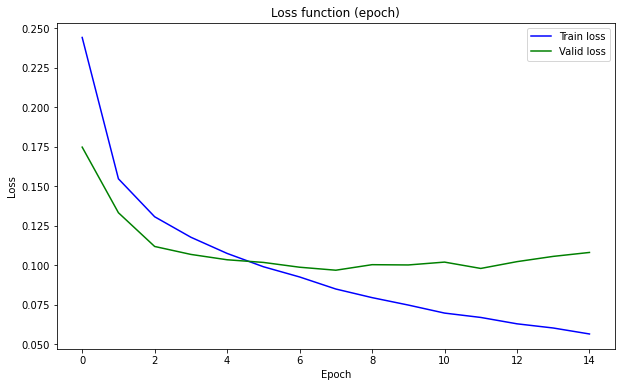

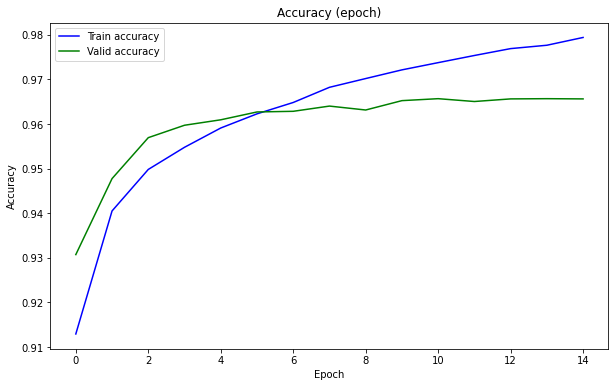

In [ ]:
lstm_model_glove=LSTM(
    {
        "vocab_size": len(word_tokenizer.vocab),
        "embedding_dim": 100,
        "lstm_hidden_dim": 100,
        "number_of_tags": 2,
        "num_layers": 2,
        "dropout": 0.5,
        "bidirectional": True,
        "pad_idx": 0
    }, weights = weights_matrix_glove
)

#print(lstm_model)
lstm_model_glove = lstm_model_glove.to(device) 

#optimizer = torch.optim.SGD(lstm_model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(lstm_model_glove.parameters())

loss_fn = torch.nn.CrossEntropyLoss()

losses, accuracies = train_epoch(lstm_model_glove, train_df, val_df, optimizer=optimizer, epochs=15, batch_size=512, GPU=True, include_length = True)


In [ ]:
pred_glove = evaluate_func(lstm_model_glove, test_df, bs = 1, GPU=True, include_length = True)

Test Accuracy:  0.962


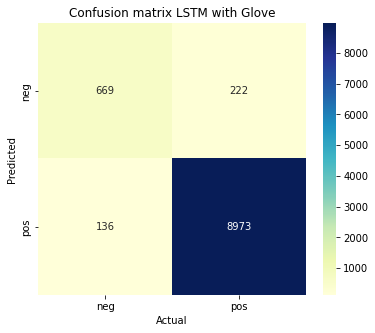

In [ ]:
cm=confusion_matrix(test_df.overall, pred_glove)
plt.figure(figsize=(6, 5))
ax = plt.axes()
sns.heatmap(cm, annot=True, xticklabels=["neg", "pos"], yticklabels=["neg", "pos"], fmt="g", cmap="YlGnBu",  ax = ax)
ax.set_title('Confusion matrix LSTM with Glove')
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

Start: 2022-05-17 20:30:59.697305
Train_df shape: (200000, 10) | Val_df shape: (20000, 10)
Epochs: 1 | Train Loss:  0.228 | Train Accuracy:  0.919 | Val Loss:  0.138 | Val Accuracy:  0.946 | End: 2022-05-17 20:31:32.744079
Epochs: 2 | Train Loss:  0.131 | Train Accuracy:  0.950 | Val Loss:  0.114 | Val Accuracy:  0.955 | End: 2022-05-17 20:32:05.812311
Epochs: 3 | Train Loss:  0.107 | Train Accuracy:  0.959 | Val Loss:  0.107 | Val Accuracy:  0.959 | End: 2022-05-17 20:32:38.927821
Epochs: 4 | Train Loss:  0.092 | Train Accuracy:  0.965 | Val Loss:  0.106 | Val Accuracy:  0.962 | End: 2022-05-17 20:33:12.018393
Epochs: 5 | Train Loss:  0.079 | Train Accuracy:  0.970 | Val Loss:  0.105 | Val Accuracy:  0.962 | End: 2022-05-17 20:33:45.127352
Epochs: 6 | Train Loss:  0.068 | Train Accuracy:  0.975 | Val Loss:  0.112 | Val Accuracy:  0.960 | End: 2022-05-17 20:34:18.224031
Epochs: 7 | Train Loss:  0.058 | Train Accuracy:  0.979 | Val Loss:  0.119 | Val Accuracy:  0.962 | End: 2022-05-17 2

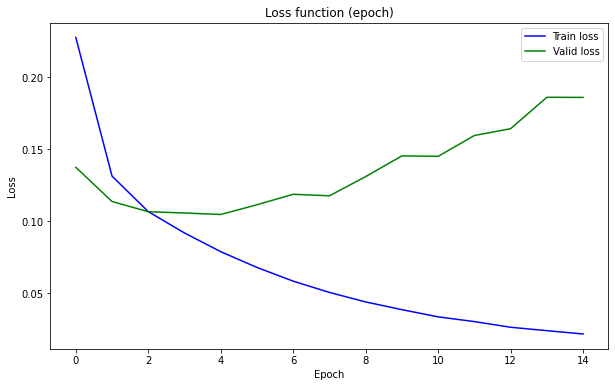

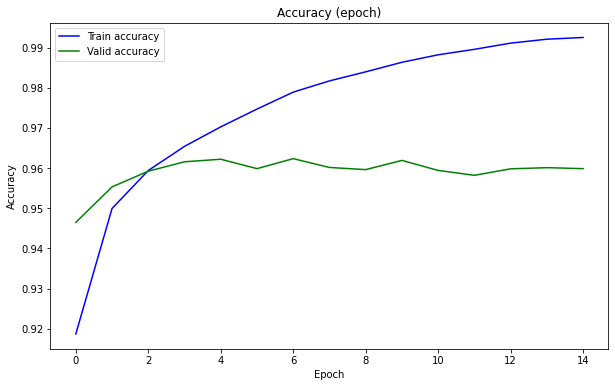

In [ ]:
#google w2v
lstm_model_w2v=LSTM(
    {
        "vocab_size": len(word_tokenizer.vocab),
        "embedding_dim": 300,
        "lstm_hidden_dim": 100,
        "number_of_tags": 2,
        "num_layers": 2,
        "dropout": 0.5,
        "bidirectional": True,
        "pad_idx": 0
    }, weights = weights_matrix_google
)

#print(lstm_model)
lstm_model_w2v = lstm_model_w2v.to(device) 

#optimizer = torch.optim.SGD(lstm_model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(lstm_model_w2v.parameters())

loss_fn = torch.nn.CrossEntropyLoss()

losses, accuracies = train_epoch(lstm_model_w2v, train_df, val_df, optimizer=optimizer, epochs=15, batch_size=512, GPU=True, include_length = True)

In [ ]:
pred_w2v = evaluate_func(lstm_model_w2v, test_df, bs = 1, GPU=True, include_length = True)

Test Accuracy:  0.959


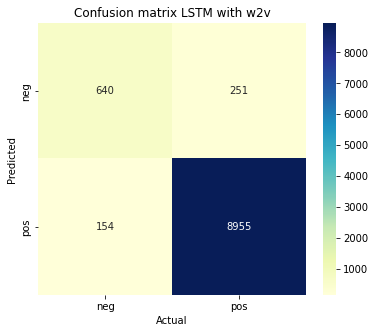

In [ ]:
cm=confusion_matrix(test_df.overall, pred_w2v)
plt.figure(figsize=(6, 5))
ax = plt.axes()
sns.heatmap(cm, annot=True, xticklabels=["neg", "pos"], yticklabels=["neg", "pos"], fmt="g", cmap="YlGnBu",  ax = ax)
ax.set_title('Confusion matrix LSTM with w2v')
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

In [ ]:
bert_pred = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/NLP/Bert_pred.csv')
pred_bert = bert_pred['pred']
#test_df[(pred_bert == 0)]

Negative

In [ ]:
#bert
with pd.option_context('display.max_colwidth', None):
  print(test_df[(test_df.overall == 0) & (np.asarray(pred_w2v) == 1) & (np.asarray(pred_glove) == 1) & (pred_bert == 0)].sort_values(by = ['reviewText'], ascending=True).sample(1, random_state = 5)['reviewText'])


6723    Omg - I do not recommend these s***ty aftermarket parts.  After spending hours on what should have been a routine ape hanger extension, I am thoroughly brassed off!  My bike is a 2012 sportster iron.  I am installing 12" burly narrow hangers.\n\nWhere do I begin?\nThe wiring harness is not long enough to do a reasonable job.  I mapped the wiring perfectly my bike didn't start.  Lo and behold, the wiring was so short (I was reasonable and stingy with my splicing cuts too) that when I turn the handlebar into tight locked position, the wiring harness strained and began to come undone which caused my right controls to cut out.  Unbelievable.\n\nNext up, the idle cable was missing a washer to retain it within the right hand controls.\n\nI'm pretty sure the thread count on the replacement clutch cable is slightly different to the 5/16-24 standard that these Harley's have.\n\nI just recommend not wasting your time or money on these dangerous and s***ty aftermarket parts.  Buy your cab

In [ ]:
#w2v
with pd.option_context('display.max_colwidth', None):
  print(test_df[(test_df.overall == 0) & (np.asarray(pred_w2v) == 0) & (np.asarray(pred_glove) == 1) & (pred_bert == 1)].sort_values(by = ['reviewText'], ascending=True).sample(1, random_state = 5)['reviewText'])


997    Call me harsh, but I like to receive what's pictured. Instead of the proper, perfect-fit-every-time crimp style clamps pictured, I received some garbage clamps that you have to fold over and secure by bending tabs. Zip ties would give a similar degree of confidence. Maybe they're easier for some kid with no mechanical experience, but I like my replacement parts to be OEM equivalent. Besides, you can get a crimp tool for something like ten bucks. Yeah, I got a boot that fits... and let's face it, it's hard to manufacture a rubber boot so poorly that it won't seal-in axle grease and flex properly for fifty to a hundred thousand miles, but I didn't buy just a boot. I bought a boot kit.
Name: reviewText, dtype: object


In [ ]:
#glove
with pd.option_context('display.max_colwidth', None):
  print(test_df[(test_df.overall == 0) & (np.asarray(pred_w2v) == 1) & (np.asarray(pred_glove) == 0) & (pred_bert == 1)].sort_values(by = ['reviewText'], ascending=True).sample(1, random_state = 5)['reviewText'])


7125    If your looking to just use to remove light brake dust it works. For one it to long. Second the bristles are too light and it's flimsy. Would buy again.
Name: reviewText, dtype: object


In [ ]:
#none
with pd.option_context('display.max_colwidth', None):
  print(test_df[(test_df.overall == 0) & (np.asarray(pred_w2v) == 1) & (np.asarray(pred_glove) == 1) & (pred_bert == 1)].sort_values(by = ['reviewText'], ascending=True).sample(1, random_state = 5)['reviewText'])


5255    Much smaller than anticipated.  Was going to use for our travel trailer but my husband wanted a larger one.
Name: reviewText, dtype: object


In [ ]:
#all
with pd.option_context('display.max_colwidth', None):
  print(test_df[(test_df.overall == 0) & (np.asarray(pred_w2v) == 0) & (np.asarray(pred_glove) == 0) & (pred_bert == 0)].sort_values(by = ['reviewText'], ascending=True).sample(1, random_state = 5)['reviewText'])


6982    At first these were amazing bright after a few months they began burning out, over time they completely failed. Even when it is 45 Degrees Fahrenheit outside they would get to hot to touch. The brackets are weak and break also over time, so be leery of what you mount them on.
Name: reviewText, dtype: object


Positive

In [ ]:
#bert
with pd.option_context('display.max_colwidth', None):
  print(test_df[(test_df.overall == 1) & (np.asarray(pred_w2v) == 0) & (np.asarray(pred_glove) == 0) & (pred_bert == 1)].sort_values(by = ['reviewText'], ascending=True).sample(1, random_state = 5)['reviewText'])


7717    It was a very good quality product, however sizing was small and I returned them and did not reorder.
Name: reviewText, dtype: object


In [ ]:
#w2v
with pd.option_context('display.max_colwidth', None):
  print(test_df[(test_df.overall == 1) & (np.asarray(pred_w2v) == 1) & (np.asarray(pred_glove) == 0) & (pred_bert == 0)].sort_values(by = ['reviewText'], ascending=True).sample(1, random_state = 5)['reviewText'])


4026    First off, this is *THE ONLY* choice for transmissions asking specifically for Mercon SP (such as my 2006 F250). Do *NOT* get tricked into using Mercon LV in place of Mercon SP - IT IS NOT THE SAME AND WILL NOT WORK THE SAME no matter who tells you it will.\n\nThe only negative I can say about this fluid is 3 of the 12 quarts leaked during shipping for a total fluid loss of about 5mL. Not enough to affect my project in any way, but nonetheless the product leaked during shipping due to caps being installed very loosely.
Name: reviewText, dtype: object


In [ ]:
#glove
with pd.option_context('display.max_colwidth', None):
  print(test_df[(test_df.overall == 1) & (np.asarray(pred_w2v) == 0) & (np.asarray(pred_glove) == 1) & (pred_bert == 0)].sort_values(by = ['reviewText'], ascending=True).sample(1, random_state = 5)['reviewText'])


2563    This is obsolete now. WOTLK was the best expansion. It has gone downhill ever since.
Name: reviewText, dtype: object


In [ ]:
#none
with pd.option_context('display.max_colwidth', None):
  print(test_df[(test_df.overall == 1) & (np.asarray(pred_w2v) == 0) & (np.asarray(pred_glove) == 0) & (pred_bert == 0)].sort_values(by = ['reviewText'], ascending=True).sample(1, random_state = 5)['reviewText'])


994    the one bracket came back broken after some transmission work. Figured after 17 years it was due. Also ordered a new boot at the same time. Both installed without a problem. 2000 Jeep TJ with 5/speed manual transmission.
Name: reviewText, dtype: object


In [ ]:
#all
with pd.option_context('display.max_colwidth', None):
  print(test_df[(test_df.overall == 1) & (np.asarray(pred_w2v) == 1) & (np.asarray(pred_glove) == 1) & (pred_bert == 1)].sort_values(by = ['reviewText'], ascending=True).sample(1, random_state = 5)['reviewText'])


4811    came fast and just what I needed..
Name: reviewText, dtype: object
